### **Simple 2D Discrete Flow Matching Code Generation Model**
In this notebook we implement from first-principles a discrete flow matching model for code generation. In particular we will train a small sized 2d dfm model on two variations of code for binary search. These two variants are first converted into a 2d grid "code space" (with each character in the code mapped to a unique index in the grid) from which we create multiple samples then feed into our dfm model for training. After training, we sample from the trained model and visualize the key stages in the generation.

<img src="assets/code.png" />

#### **Discrete Flow Matching (DFM)** 
DFM is a non-autoregressive generative modeling framework recently introduced in this <a href="https://arxiv.org/pdf/2407.15595">paper</a> by meta. 
At its core, DFM defines a probability path $(p_t(x))$ that smoothly transitions between a simple source distribution $(p_0(x))$ (e.g., uniform noise or masked data) and a target distribution \(p_1(x)\) (e.g., structured data like code snippets). This path is parameterized using a time-dependent scheduler $(\kappa_t)$, allowing the model to learn how to transform from $(p_0)$ to $(p_1)$.

The model is trained by minimizing the KL divergence between the true probability path and the one predicted by the model:
$$
[
\mathcal{L} = \text{KL}(p_t(x | x_0, x_1) || \text{model output}).
]
$$

Once trained, the model can generate samples by starting from $(p_0)$ and following the learned flow to $(p_1)$.


#### **Summary**

- **Text Data Preparation**: We define two variations of binary search code and convert them into a 2D grid representation.
- **Discrete Flow Matching Model**: We implement a small MLP-based DFM model to learn the probability path.
- **Training**: The model is trained to predict the flow from uniform noise to structured code.
- **Visualization**: We visualize the denoising process over multiple stages, showing how the model progressively reconstructs the code.
- **Sample Generation**: Finally, we generate samples from the trained model and display the reconstructed code.


Using cpu.
Starting training...
| iter      1 | loss    9.191 | 87.40 ms/step
| iter      2 | loss    6.779 | 27.67 ms/step
| iter      3 | loss    6.023 | 26.16 ms/step
| iter      4 | loss    4.708 | 26.14 ms/step
| iter      5 | loss    4.874 | 35.41 ms/step
| iter      6 | loss    5.247 | 93.86 ms/step
| iter      7 | loss    3.683 | 23.49 ms/step
| iter      8 | loss    4.357 | 24.60 ms/step
| iter      9 | loss    3.821 | 21.42 ms/step
| iter     10 | loss    3.576 | 22.28 ms/step
| iter     11 | loss    4.295 | 24.09 ms/step
| iter     12 | loss    3.431 | 21.89 ms/step
| iter     13 | loss    4.233 | 22.67 ms/step
| iter     14 | loss    3.539 | 21.21 ms/step
| iter     15 | loss    3.043 | 21.88 ms/step
| iter     16 | loss    4.614 | 36.99 ms/step
| iter     17 | loss    3.623 | 29.18 ms/step
| iter     18 | loss    3.023 | 24.48 ms/step
| iter     19 | loss    3.102 | 28.39 ms/step
| iter     20 | loss    2.992 | 29.66 ms/step
| iter     21 | loss    2.966 | 30.91 ms/step
| 

NFE: 32: 100%|██████████| 1.0/1.0 [00:01<00:00,  1.81s/it]    


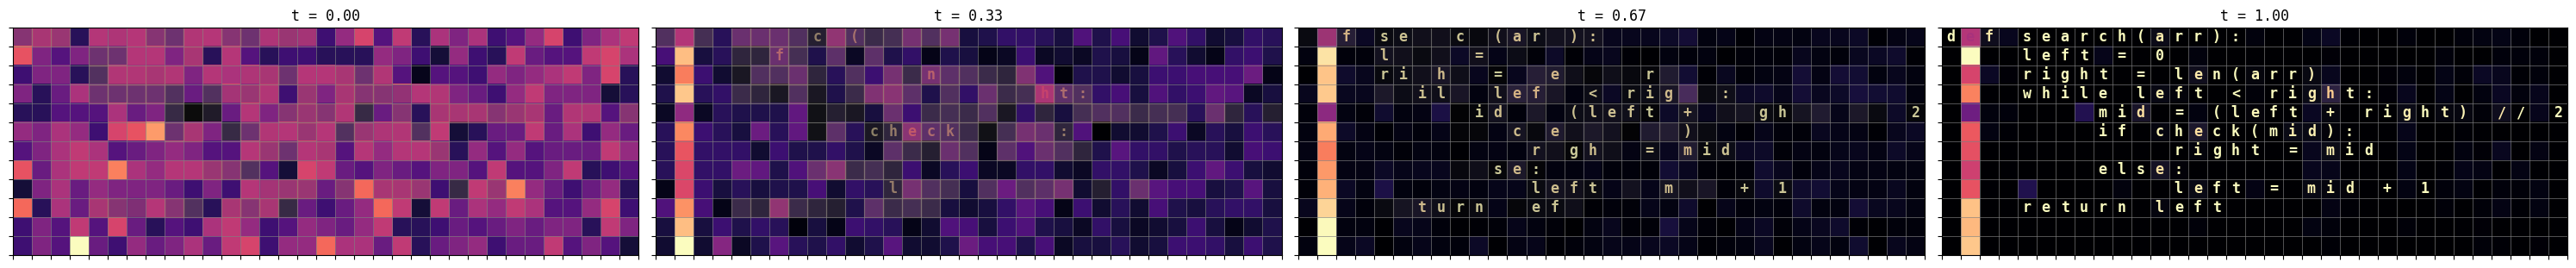


Sample generated code:
 ef    r   a

             e  a  )
       le  eft     ght:
          d     e   +   g t) //
           c e  ( id):
             i  t   m d
           e:
             e     mid
    r    n l f




In [117]:
import time
import torch
from torch import nn, Tensor
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver import MixtureDiscreteEulerSolver
from flow_matching.utils import ModelWrapper
from flow_matching.loss import MixturePathGeneralizedKL
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')

torch.manual_seed(42)

# ==============================
# Text data: binary search code
# ==============================
code_patterns = [
    """def search(arr):
    left = 0
    right = len(arr)
    while left < right:
        mid = (left + right) // 2
        if check(mid):
            right = mid
        else:
            left = mid + 1
    return left""",
    """def binary(nums, x):
    start = 0
    end = len(nums)
    while start < end:
        mid = (start + end) // 2
        if nums[mid] == x:
            return mid
        if nums[mid] < x:
            start = mid + 1
        else:
            end = mid
    return -1"""
]

# ================================
# Transform code data into 2D grid
# ================================
all_chars = set()
max_rows = 0
max_cols = 0
for pattern in code_patterns:
    lines = pattern.split('\n')
    max_rows = max(max_rows, len(lines))
    max_cols = max(max_cols, max(len(line) for line in lines))
    all_chars.update(set(pattern))

if ' ' not in all_chars:
    all_chars.add(' ')

chars = sorted(list(all_chars))
char_to_idx = {c: i for i, c in enumerate(chars)} 
idx_to_char = {i: c for c, i in char_to_idx.items()}

def create_code_grid(code):
    grid = np.zeros((max_rows, max_cols), dtype=np.int64)
    lines = code.split('\n')
    for i, line in enumerate(lines):
        for j, char in enumerate(line):
            if j < max_cols:
                grid[i, j] = char_to_idx.get(char, char_to_idx[' '])
        if len(line) < max_cols:
            grid[i, len(line):] = char_to_idx[' ']
    if len(lines) < max_rows:
        grid[len(lines):, :] = char_to_idx[' ']
    return grid

pattern_grids = [create_code_grid(code) for code in code_patterns]

def inf_train_gen(batch_size: int = 200, device: str = "cpu") -> Tensor:
    batch_x1 = []
    batch_x2 = []
    for _ in range(batch_size):
        pattern_idx = np.random.randint(0, len(pattern_grids))
        pattern = pattern_grids[pattern_idx]
        row = np.random.randint(0, max_rows)
        col = np.random.randint(0, max_cols)
        char_idx = pattern[row, col]
        batch_x1.append(row)
        batch_x2.append(char_idx)
    x1 = torch.tensor(batch_x1, device=device)
    x2 = torch.tensor(batch_x2, device=device)
    return torch.stack([x1, x2], dim=1)

class Swish(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x)*x

# ==============================
# MLP
# ==============================
class MLP(nn.Module):
    def __init__(self, input_dim: int = 128, time_dim: int = 16, hidden_dim=256):
        super().__init__()
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        self.time_embedding = nn.Sequential(
            nn.Linear(1, time_dim),
            Swish(),
            nn.Linear(time_dim, time_dim)
        )
        self.token_embedding = nn.Sequential(
            nn.Embedding(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        self.main = nn.Sequential(
            nn.Linear(hidden_dim*2 + time_dim, hidden_dim*2),
            Swish(),
            nn.LayerNorm(hidden_dim*2),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            Swish(),
            nn.LayerNorm(hidden_dim*2),
            nn.Linear(hidden_dim*2, hidden_dim),
            Swish(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, input_dim*2)
        )
    def forward(self, x, t):
        t = self.time_embedding(t.unsqueeze(-1))
        x = self.token_embedding[0](x)
        x = self.token_embedding[1](x)
        B, N, d = x.shape
        x = x.reshape(B, N*d)
        h = torch.cat([x, t], dim=1)
        h = self.main(h)
        return h.reshape(B, N, self.input_dim)

# =========================
# Training the model
# =========================
source_distribution = "uniform"  # Use "mask" to change behavior
lr = 0.001
batch_size = 1024
iterations = 500
print_every = 1
vocab_size = len(chars)
hidden_dim = 256
epsilon = 1e-3

probability_denoiser = MLP(input_dim=vocab_size, time_dim=16, hidden_dim=hidden_dim).to(device)
scheduler = PolynomialConvexScheduler(n=2.0)
path = MixtureDiscreteProbPath(scheduler=scheduler)
optimizer = torch.optim.AdamW(probability_denoiser.parameters(), lr=lr, weight_decay=0.01)
loss_fn = MixturePathGeneralizedKL(path=path)

print("Starting training...")
start_time = time.time()
for i in range(iterations):
    optimizer.zero_grad()
    x_1 = inf_train_gen(batch_size=batch_size, device=device)
    x_0 = torch.randint_like(x_1, high=vocab_size) if source_distribution == "uniform" else torch.zeros_like(x_1)
    t = torch.rand(x_1.shape[0], device=device)*(1 - epsilon)
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    logits = probability_denoiser(x=path_sample.x_t, t=path_sample.t)
    loss = loss_fn(logits=logits, x_1=x_1, x_t=path_sample.x_t, t=path_sample.t)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(probability_denoiser.parameters(), max_norm=1.0)
    optimizer.step()
    if (i+1) % print_every == 0:
        elapsed = time.time()-start_time
        print(f'| iter {i+1:6d} | loss {loss.item():8.3f} | {elapsed*1000/print_every:5.2f} ms/step')
        start_time = time.time()

print("Training completed.")

# ========================
# Sampling from the model
# ========================
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return torch.softmax(self.model(x, t), dim=-1)

wrapped_probability_denoiser = WrappedModel(probability_denoiser)
solver = MixtureDiscreteEulerSolver(model=wrapped_probability_denoiser, path=path, vocabulary_size=vocab_size)

nfe = 32
step_size = 1 / nfe
n_samples = 10000
dim = 2
x_init = torch.randint(size=(n_samples, dim), high=vocab_size, device=device)
n_plots = 4
linspace_to_plot = torch.linspace(0, 1.0, n_plots)

print("Sampling from trained model...")
sol = solver.sample(
    x_init=x_init,
    step_size=step_size,
    verbose=True,
    return_intermediates=True,
    time_grid=linspace_to_plot
)
sol = sol.cpu().numpy()

plt.rcParams['font.family'] = 'monospace'
fig, axs = plt.subplots(1, n_plots, figsize=(30, 10))
colormap = 'magma'

for idx, t_ in enumerate(linspace_to_plot):
    ax = axs[idx]
    sol_step = sol[idx]
    counts = np.zeros((max_rows, max_cols), dtype=int)
    for (r, c) in sol_step:
        r = int(r)
        c = int(c)
        if 0 <= r < max_rows and 0 <= c < max_cols:
            counts[r, c] += 1

    # Normalize counts for colormap
    norm = colors.Normalize(vmin=counts.min(), vmax=counts.max())
    img = ax.imshow(counts, cmap=colormap, norm=norm, aspect='equal')

    for rr in range(max_rows):
        for cc in range(max_cols):
            char_idx_ = pattern_grids[0][rr, cc]
            ch = idx_to_char[char_idx_]
            if ch != ' ':
                tile_opacity = counts[rr, cc] / counts.max() if counts.max() > 0 else 0
                rect_color = plt.cm.magma_r(norm(counts[rr, cc]))

                rect = plt.Rectangle(
                    (cc - 0.5, rr - 0.5),
                    1,
                    1,
                    fill=True,
                    color=rect_color,
                    alpha=tile_opacity,
                )
                ax.add_patch(rect)

                if idx > 0:
                    if idx == 1 and np.random.rand() < 0.2: 
                        text_opacity = 0.5
                    elif idx == 2 and np.random.rand() < 0.5:  
                        text_opacity = 0.8
                    elif idx == 3:
                        text_opacity = 1.0
                    else:
                        continue  

                    ax.text(
                        cc,
                        rr,
                        ch,
                        color=(rect_color[0], rect_color[1], rect_color[2], text_opacity),
                        fontsize=12,
                        ha="center",
                        va="center",
                        fontweight="bold",
                    )

    ax.set_xticks(np.arange(-0.5, max_cols, 1))
    ax.set_yticks(np.arange(-0.5, max_rows, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True, color="gray", linestyle="-", linewidth=0.5, alpha=0.9)
    ax.set_title(f"t = {t_:.2f}")
    ax.set_xlim(-0.5, max_cols - 0.5)
    ax.set_ylim(-0.5, max_rows - 0.5)
    ax.invert_yaxis()

plt.tight_layout()
plt.show()

# ========================
# Final code generation
# ========================
print("\nSample generated code:")
final_sol = sol[-1]
final_counts = np.zeros((max_rows, max_cols), dtype=int)
for (r, c) in final_sol:
    r = int(r)
    c = int(c)
    if 0 <= r < max_rows and 0 <= c < max_cols:
        final_counts[r, c] += 1
final_chars = np.full((max_rows, max_cols), ' ')
for rr in range(max_rows):
    for cc in range(max_cols):
        if final_counts[rr, cc] > 0:
            char_idx_ = pattern_grids[0][rr, cc]
            final_chars[rr, cc] = idx_to_char[char_idx_]

for rr in range(max_rows):
    print(''.join(final_chars[rr, :]).rstrip())